In [208]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

%matplotlib inline

In [9]:
# Copyright 2015-2016 Carnegie Mellon University
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Module for dlib-based alignment."""

import cv2
import dlib
import numpy as np
from numpy.linalg import inv

#: Landmark indices corresponding to the inner eyes and bottom lip.
INNER_EYES_AND_BOTTOM_LIP = [39, 42, 57]

#: Landmark indices corresponding to the outer eyes and nose.
OUTER_EYES_AND_NOSE = [36, 45, 33]


TEMPLATE = np.float32([
    (0.0792396913815, 0.339223741112), (0.0829219487236, 0.456955367943),
    (0.0967927109165, 0.575648016728), (0.122141515615, 0.691921601066),
    (0.168687863544, 0.800341263616), (0.239789390707, 0.895732504778),
    (0.325662452515, 0.977068762493), (0.422318282013, 1.04329000149),
    (0.531777802068, 1.06080371126), (0.641296298053, 1.03981924107),
    (0.738105872266, 0.972268833998), (0.824444363295, 0.889624082279),
    (0.894792677532, 0.792494155836), (0.939395486253, 0.681546643421),
    (0.96111933829, 0.562238253072), (0.970579841181, 0.441758925744),
    (0.971193274221, 0.322118743967), (0.163846223133, 0.249151738053),
    (0.21780354657, 0.204255863861), (0.291299351124, 0.192367318323),
    (0.367460241458, 0.203582210627), (0.4392945113, 0.233135599851),
    (0.586445962425, 0.228141644834), (0.660152671635, 0.195923841854),
    (0.737466449096, 0.182360984545), (0.813236546239, 0.192828009114),
    (0.8707571886, 0.235293377042), (0.51534533827, 0.31863546193),
    (0.516221448289, 0.396200446263), (0.517118861835, 0.473797687758),
    (0.51816430343, 0.553157797772), (0.433701156035, 0.604054457668),
    (0.475501237769, 0.62076344024), (0.520712933176, 0.634268222208),
    (0.565874114041, 0.618796581487), (0.607054002672, 0.60157671656),
    (0.252418718401, 0.331052263829), (0.298663015648, 0.302646354002),
    (0.355749724218, 0.303020650651), (0.403718978315, 0.33867711083),
    (0.352507175597, 0.349987615384), (0.296791759886, 0.350478978225),
    (0.631326076346, 0.334136672344), (0.679073381078, 0.29645404267),
    (0.73597236153, 0.294721285802), (0.782865376271, 0.321305281656),
    (0.740312274764, 0.341849376713), (0.68499850091, 0.343734332172),
    (0.353167761422, 0.746189164237), (0.414587777921, 0.719053835073),
    (0.477677654595, 0.706835892494), (0.522732900812, 0.717092275768),
    (0.569832064287, 0.705414478982), (0.635195811927, 0.71565572516),
    (0.69951672331, 0.739419187253), (0.639447159575, 0.805236879972),
    (0.576410514055, 0.835436670169), (0.525398405766, 0.841706377792),
    (0.47641545769, 0.837505914975), (0.41379548902, 0.810045601727),
    (0.380084785646, 0.749979603086), (0.477955996282, 0.74513234612),
    (0.523389793327, 0.748924302636), (0.571057789237, 0.74332894691),
    (0.672409137852, 0.744177032192), (0.572539621444, 0.776609286626),
    (0.5240106503, 0.783370783245), (0.477561227414, 0.778476346951)])

TPL_MIN, TPL_MAX = np.min(TEMPLATE, axis=0), np.max(TEMPLATE, axis=0)
MINMAX_TEMPLATE = (TEMPLATE - TPL_MIN) / (TPL_MAX - TPL_MIN)


def align(imgDim, rgbImg, landmarks, landmarkIndices=INNER_EYES_AND_BOTTOM_LIP):
    r"""align_v2(imgDim, rgbImg, bb=None, landmarks=None, landmarkIndices=INNER_EYES_AND_BOTTOM_LIP)

    Transform and align a face in an image.

    Uses the inverse of the desired template output points to calculate a transformation
    matrix that relates output pixel coordinates to input pixel coordinates.
    The transform matrix is multiplied with the pixel coordinates of the output image and
    returns the corresponding pixel coordinates in the input image and interpolates over those
    pixels and assigns the value to the output pixel.

    :author: Dante Knowles | godrek@gmail.com | https://github.com/Godrek
    :param imgDim: The edge length in pixels of the square the image is resized to.
    :type imgDim: int
    :param rgbImg: RGB image to process. Shape: (height, width, 3)
    :type rgbImg: numpy.ndarray
    :param landmarks: Detected landmark locations. \
                      Landmarks found on `bb` if not provided.
    :type landmarks: list of (x,y) tuples
    :param landmarkIndices: The indices to transform to.
    :type landmarkIndices: list of ints
    :return: The aligned RGB image. Shape: (imgDim, imgDim, 3)
    :rtype: numpy.ndarray
    """
    assert imgDim is not None
    assert rgbImg is not None
    assert landmarkIndices is not None

    npLandmarks = np.float32(landmarks)
    npLandmarkIndices = np.array(landmarkIndices)
    templateLandmarks = MINMAX_TEMPLATE[npLandmarkIndices]

    fidPoints = npLandmarks[npLandmarkIndices]

    # create output pixel mat
    templateMat = np.ones((3, 3), dtype=np.float32)
    for i in range(3):
        for j in range(2):
            templateMat[i][j] = templateLandmarks[i][j] * imgDim

    templateMat = np.transpose(inv(templateMat))

    # create transformation matrix from output pixel coordinates to input
    # pixel coordinates
    H = np.zeros((2, 3), dtype=np.float32)
    for i in range(3):
        H[0][i] = fidPoints[0][0] * templateMat[0][i] + fidPoints[1][0] * \
            templateMat[1][i] + fidPoints[2][0] * templateMat[2][i]
        H[1][i] = fidPoints[0][1] * templateMat[0][i] + fidPoints[1][1] * \
            templateMat[1][i] + fidPoints[2][1] * templateMat[2][i]

    imgWidth = np.shape(rgbImg)[1]
    imgHeight = np.shape(rgbImg)[0]
    thumbnail = np.zeros((imgDim, imgDim, 3), np.uint8)

    # interpolation from input image to output pixels using transformation mat H to compute
    # which input coordinates map to output
    for y in range(imgDim):
        for x in range(imgDim):
            xprime = x * H[0][1] + y * H[0][0] + H[0][2]
            yprime = x * H[1][1] + y * H[1][0] + H[1][2]
            tx = int(xprime)
            ty = int(yprime)
            horzOffset = 1
            vertOffset = 1
            if(tx < 0 or tx >= imgWidth or ty < 0 or ty >= imgHeight):
                continue
            if(tx == imgWidth - 1):
                horzOffset = 0
            if(ty == imgHeight - 1):
                vertOffset = 0
            f1 = xprime - float(tx)
            f2 = yprime - float(ty)
            upperLeft = rgbImg[ty][tx]
            upperRight = rgbImg[ty][tx + horzOffset]
            bottomLeft = rgbImg[ty + vertOffset][tx]
            bottomRight = rgbImg[ty + vertOffset][tx + horzOffset]

            thumbnail[x][y][0] = upperLeft[0] * (1.0 - f1) * (1.0 - f2) + upperRight[0] * f1 * (
                1.0 - f2) + bottomLeft[0] * (1.0 - f1) * f2 + bottomRight[0] * f1 * f2
            thumbnail[x][y][1] = upperLeft[1] * (1.0 - f1) * (1.0 - f2) + upperRight[1] * f1 * (
                1.0 - f2) + bottomLeft[1] * (1.0 - f1) * f2 + bottomRight[1] * f1 * f2
            thumbnail[x][y][2] = upperLeft[2] * (1.0 - f1) * (1.0 - f2) + upperRight[2] * f1 * (
                1.0 - f2) + bottomLeft[2] * (1.0 - f1) * f2 + bottomRight[2] * f1 * f2

    return thumbnail


In [2]:
import pyspark
sc = pyspark.SparkContext('yarn-client')

In [12]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("dlib/shape_predictor_68_face_landmarks.dat")

In [195]:
import skimage
import skimage.io as io
from skimage.draw import circle

from io import BytesIO

from PIL import Image
import numpy as np

# img is np array 
def do_parts(parts):
    return [(p.x,p.y) for p in parts]
def find_bits(img):
    dets = detector(img, 1)
    return [([d.left(), d.top(), d.right(), d.bottom()], do_parts(predictor(img,d).parts())) for k, d in enumerate(dets)]

def decode_image(raw):
  im = Image.open(BytesIO(raw))
  #im = im.rotate(-90)
  return im

def resize_image(img):
    #img.thumbnail((640,640), Image.ANTIALIAS)
    return img
    
def convert_image(img):
    return np.array(img)

def draw_spots(image, spots):
    for spot in spots:
        rr, cc = circle(spot[1], spot[0], 3)
        image[rr, cc,:] = (255,0,0)
        
    return image;
    

Faces found per image:
[2]


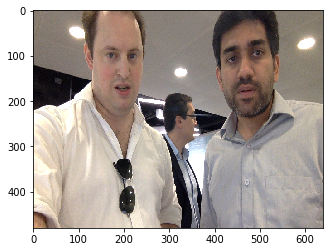

In [209]:
# local version
from glob import glob

files = glob("faces/raw/*.png")

# load the file to bytes
def load_image(file):
    with open(file, "rb") as fh: 
        return bytearray(fh.read())
    
images = map(load_image, files)
images = map(decode_image, images)
images = map(resize_image, images)
images = list(map(convert_image, images))

plt.imshow(list(images)[0])
detected = list(map(lambda x: (x, find_bits(x)),images))

aligned = map(lambda x: [align(128, x[0], y[1]) for y in x[1]],detected)
marked_up = map(lambda x: [draw_spots(x[0], y[1]) for y in x[1]],detected)

aligned_l = list(filter(lambda i: len(i) > 0,aligned))
marked_up_l = list(marked_up)

print ("Faces found per image:")
print (list(map(len,aligned_l)))



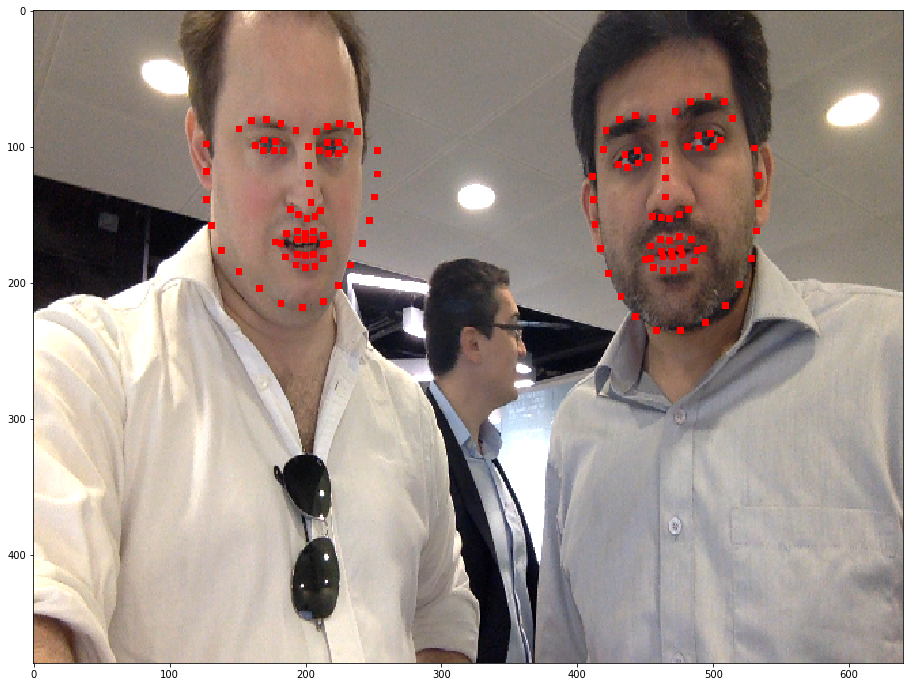

In [210]:
# aligned_l is indexed by file, then face id in file
img = np.asarray(marked_up_l[0][0])
plt.figure(figsize=(16, 12))
plt.imshow(img)

AxesImage(54,36;334.8x217.44)


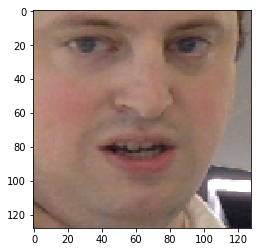

In [217]:
print(plt.imshow(np.asarray(aligned_l[0][1])))
#print(plt.imshow(np.asarray(aligned_l[0][0])))

In [5]:
# spark version 
files = sc.binaryFiles("faces/raw", 100)
images = files.mapValues(decode_image).mapValues(convert_image)

detected = images.mapValues(lambda x: (x, find_bits(x)))

aligned = detected.mapValues(lambda x: [align(128, x[0], y[1]) for y in x[1]])
marked_up = detected.mapValues(lambda x: [draw_spots(x[0], y[1]) for y in x[1]])

print (aligned.count())
print (marked_up.count())

AttributeError: 'list' object has no attribute 'map'